In [1]:
import numpy as np
import pandas as pd
import random
import datetime

import warnings

from sklearn import svm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import category_encoders as ce

from imblearn.over_sampling import SMOTEN

In [2]:
inputData_chunks = pd.read_csv('C:/Users/enggj/Downloads/avazu-ctr-prediction/train/train.csv', chunksize=1000000)
kaggleData = pd.read_csv('C:/Users/enggj/Downloads/avazu-ctr-prediction/test/test.csv')

In [3]:
sampleSize = 0
for chunk in inputData_chunks:
    sampleSize += chunk.shape[0]

print('Total input data records are {}'.format(sampleSize))

Total input data records are 40428967


In [4]:
trainSize = 100000
valSize = 10000
testSize = 10000

skip_rows = sorted(random.sample(range(1,sampleSize), sampleSize - (trainSize+valSize+testSize)))

inputData = pd.DataFrame()
inputData = pd.read_csv('C:/Users/enggj/Downloads/avazu-ctr-prediction/train/train.csv', skiprows=skip_rows, parse_dates=['hour'], date_parser = lambda val : pd.datetime.strptime(val, '%y%m%d%H'))

inputData = inputData.drop(['id'], axis=1)

C:\Users\enggj\AppData\Local\Temp\ipykernel_27108\529836552.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  inputData = pd.read_csv('C:/Users/enggj/Downloads/avazu-ctr-prediction/train/train.csv', skiprows=skip_rows, parse_dates=['hour'], date_parser = lambda val : pd.datetime.strptime(val, '%y%m%d%H'))


In [5]:
inputData.to_pickle("C:/Users/enggj/Downloads/mss_portfolio/inputData.pkl") 

In [2]:
inputData = pd.read_pickle("C:/Users/enggj/Downloads/mss_portfolio/inputData.pkl")

### Data Split

In [3]:
continuous_variables = list(inputData.columns[inputData.dtypes=='int64'][1:].values)
disguised_cols = ['C1', 'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15','C16','C17','C18','C19','C20','C21']
[continuous_variables.remove(col) for col in disguised_cols]
categorical_variables = list(inputData.columns[inputData.dtypes=='O'].values)
categorical_variables.extend(disguised_cols)

y = inputData['click']
X_train, X_test, y_train, y_test = train_test_split(inputData.loc[:,categorical_variables], y, test_size=0.15, random_state=42, stratify=y)

### 1. Exploratory Data Analysis

##### 1.1 Class Imbalance

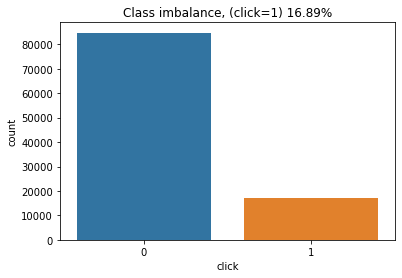

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics 

sns.countplot(x='click',data=pd.concat([X_train,y_train],axis=1))
plt.title("Class imbalance, (click=1) "+ str(round(100*sum(y_train==1)/X_train.shape[0],2))+"%")
plt.show()

##### 1.2 Empirical probabilities of CTR; for categorical covariates

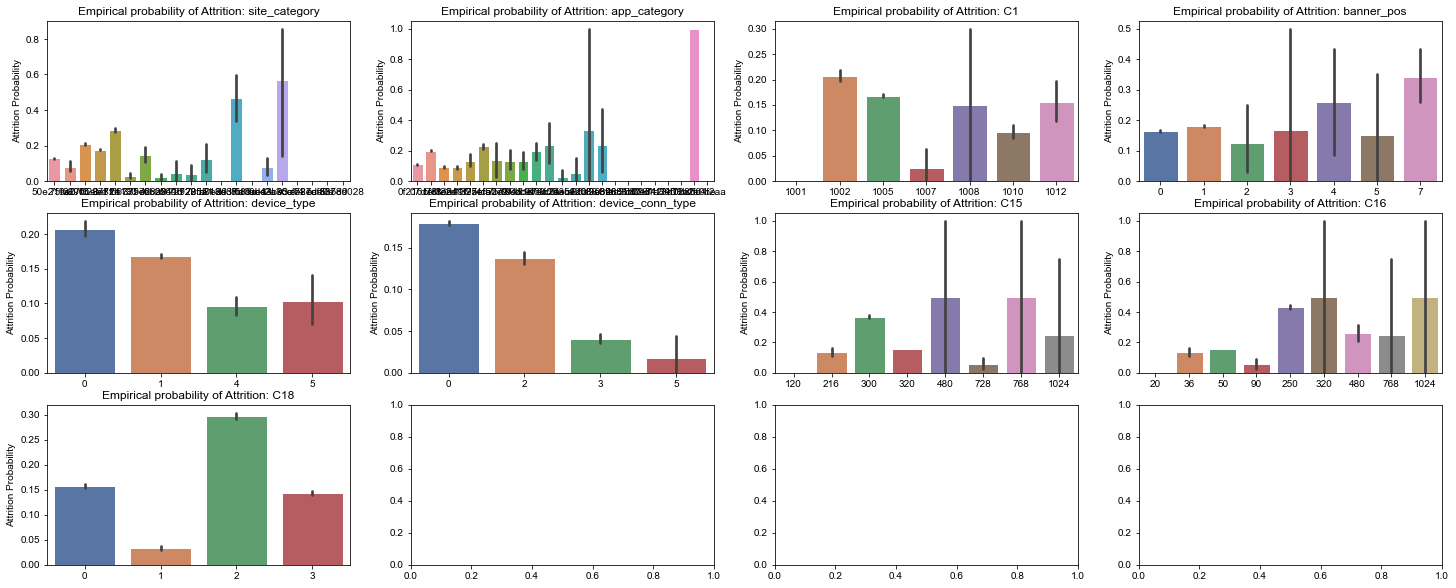

In [5]:
def covariate_empirical_prob(all_data,xcol,ax):
    sns.set(style="darkgrid")
    sns.barplot(data=all_data, x=xcol, y=all_data.click,ax=ax)
    ax.set_title("Empirical probability of Attrition: "+xcol)
    ax.set_ylabel("Attrition Probability")
    ax.set_xlabel("")
    

fig,ax = plt.subplots(3,4)
fig.set_figwidth(25)
fig.set_figheight(10)

features_subset_visualize = pd.concat([X_train.loc[:,X_train.nunique()<25], y_train],axis=1)
for i,xcol in enumerate(features_subset_visualize.columns[:-1]):
    covariate_empirical_prob(features_subset_visualize,xcol,ax[int(i/4),int(i%4)])
plt.show()



##### 1.3 Missing Data check

In [6]:
inputData.isnull().any().any()

False

### 2. Encoding categorical data

In [15]:
encoding_one_hot = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
    ]
)

encoding_ordinal = Pipeline(
    steps=[
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ]
)

encoding_binary = Pipeline(
    steps=[
        ("encoder", ce.BinaryEncoder(handle_unknown="value"))
    ]
)

encoding_frequency_01 = Pipeline(
    steps=[
        ("encoder", ce.CountEncoder(handle_unknown="value", normalize=True, min_group_size=0.01))
    ]
)

encoding_frequency_10 = Pipeline(
    steps=[
        ("encoder", ce.CountEncoder(handle_unknown="value", normalize=True, min_group_size=0.10))
    ]
)

encoding_target = Pipeline(
    steps=[
        ("encoder", ce.TargetEncoder(handle_unknown="value"))
    ]
)

encoding_hash = Pipeline(
    steps=[
        ("encoder", ce.HashingEncoder(n_components=32))
    ]
)

encoding_quantile = Pipeline(
    steps=[
        ("encoder", ce.QuantileEncoder(quantile=0.5, handle_missing='value'))
    ]
)

encoding_woe = Pipeline(
    steps=[
        ("encoder", ce.woe.WOEEncoder(handle_missing='value'))
    ]
)

In [16]:
def get_results(algoName,clf,param_grid,X_train, y_train,X_test, y_test):
    search_cv = RandomizedSearchCV(clf, param_grid, n_iter=5, random_state=0, scoring='roc_auc', cv=5, verbose=2, refit=True)
    search_cv.fit(X_train, y_train)
    output = [algoName, search_cv.best_score_, search_cv.score(X_test, y_test)]
    return output

def get_preprocessor(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables):
    preprocessor = ColumnTransformer(
        transformers=[
            ("cat_low", encoding_low_cardinal, low_cardinal_variables),
            ("cat_high", encoding_high_cardinal, high_cardinal_variables),            
        ]
    )
    return preprocessor

In [17]:
def fit_logistic(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test):
    print("Fitting Logistic Regression")
    warnings.filterwarnings('ignore')
    preprocessor = get_preprocessor(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables)

    clf = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=100, solver='liblinear'))]
    )
    param_grid = {
        "classifier__C": [0.01, 0.1, 1, 10, 100],
        "classifier__penalty": ['l1', 'l2'],
    }
    output = get_results("Logistic Regression",clf,param_grid,X_train, y_train,X_test, y_test)
    return output

In [18]:
def fit_gradient_boosting(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test):
    print("Fitting Gradient Boosting Trees")
    warnings.filterwarnings('ignore')
    preprocessor = get_preprocessor(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables)

    clf = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingClassifier())]
    )
    param_grid = {
        "classifier__n_estimators": [50, 75, 100],
        "classifier__min_samples_split": [2, 5, 9],
        "classifier__max_depth": [1, 5, 9], 
        "classifier__max_features": ['sqrt', 'log2', None],                       
    }
    output = get_results("Gradient Boosting",clf,param_grid,X_train, y_train,X_test, y_test)
    return output


In [19]:
def fit_random_forest(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test):
    print("Fitting Random Forest")
    warnings.filterwarnings('ignore')
    preprocessor = get_preprocessor(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables)

    clf = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
    )

    param_grid = {
        "classifier__n_estimators": [50, 75, 100],
        "classifier__min_samples_split": [2, 5, 9],
        "classifier__max_depth": [1, 5, 9], 
        "classifier__max_features": ['sqrt', 'log2', None],                       
    }
    output = get_results("Random Forest",clf,param_grid,X_train, y_train,X_test, y_test)
    return output


In [20]:
def fit_svm(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test):
    print("Fitting SVM")
    warnings.filterwarnings('ignore')
    preprocessor = get_preprocessor(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables)

    clf = Pipeline(
        steps=[("preprocessor", preprocessor), ("scale", StandardScaler(with_mean=False)), ("classifier", svm.SVC())]
    )

    param_grid = {
        "classifier__C": [-4, 1, 6],
        "classifier__kernel": ['rbf'],
    }
    output = get_results("SVM",clf,param_grid,X_train, y_train,X_test, y_test)
    return output


In [21]:
def fit_models(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test):
    res = fit_logistic(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test)
    res1 = fit_gradient_boosting(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test)
    res2 = fit_random_forest(encoding_low_cardinal,encoding_high_cardinal,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test)
    output = pd.DataFrame([res,res1,res2], columns=["Model","Avg CV score", "Test score"])
    return output

In [35]:
HCT = 0

##### 2.1 One Hot Encoding: 

In [36]:
cardinality = X_train.apply(lambda x: len(x.unique()), axis=0).to_frame(name="cardinality")
print(cardinality)
print("One hot encoding leads to {} columns".format(cardinality.sum()[0]))

low_cardinal_variables = cardinality[cardinality['cardinality']<HCT].index.values
high_cardinal_variables = cardinality[cardinality['cardinality']>=HCT].index.values

                  cardinality
site_id                  1487
site_domain              1351
site_category              20
app_id                   1339
app_domain                 97
app_category               23
device_id               17368
device_ip               79135
device_model             3198
C1                          7
banner_pos                  7
device_type                 4
device_conn_type            4
C14                      1701
C15                         8
C16                         9
C17                       395
C18                         4
C19                        64
C20                       155
C21                        60
One hot encoding leads to 106436 columns


In [15]:

output_oneHot = fit_models(encoding_one_hot,encoding_one_hot,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test)
output_oneHot['Encoding'] = "One Hot Encoding"


Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   6.4s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   5.0s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   9.8s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   5.0s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   6.3s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  12.9s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  14.0s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  14.1s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  17.2s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  16.1s
[CV] END ............classifier__C=1, classifier__penalty=l1; total time=  15.7s
[CV] END ............

##### 2.2 Ordinal Encoding:

In [17]:
output_ordinal = fit_models(encoding_one_hot,encoding_ordinal,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test)
output_ordinal['Encoding'] = "Ordinal Encoding"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   2.7s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   3.4s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   2.9s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   1.9s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   1.5s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   2.2s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   2.0s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   1.6s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   1.7s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   2.1s
[CV] END ............classifier__C=1, classifier__penalty=l1; total time=   1.8s
[CV] END ............

##### 2.3 Binary Encoding:

In [19]:
encoder = ce.BinaryEncoder(cols=categorical_variables, handle_unknown="value")
df = encoder.fit_transform(X_train)
print("Binary Encoding leads to {} columns".format(len(df.columns)))

Binary Encoding leads to 158 columns


In [20]:
output_binary = fit_models(encoding_one_hot,encoding_binary,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test)
output_binary['Encoding'] = "Binary Encoding"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  21.3s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  21.9s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  15.9s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  14.0s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  14.6s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  15.1s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  14.5s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  15.2s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  15.8s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  16.8s
[CV] END ............classifier__C=1, classifier__penalty=l1; total time=  16.7s
[CV] END ............

##### 2.4 : Frequency Encoding

In [37]:
output_frequency_01 = fit_models(encoding_one_hot,encoding_frequency_01,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test)
output_frequency_01['Encoding'] = "Frequency Encoding 01"

output_frequency_10 = fit_models(encoding_one_hot,encoding_frequency_10,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test)
output_frequency_10['Encoding'] = "Frequency Encoding 10"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   8.9s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  11.5s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  11.6s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  11.3s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  10.9s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   9.0s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  10.7s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  14.8s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  11.6s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  10.1s
[CV] END ............classifier__C=1, classifier__penalty=l1; total time=   9.2s
[CV] END ............

##### 2.5 : Target Encoding

In [22]:

output_target = fit_models(encoding_one_hot,encoding_target,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test)
output_target['Encoding'] = "Target Encoding"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   4.1s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   5.0s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   4.0s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   3.4s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   4.4s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   4.2s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   4.4s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   4.0s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   5.6s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   4.6s
[CV] END ............classifier__C=1, classifier__penalty=l1; total time=   3.3s
[CV] END ............

##### 2.6 : Hashing

In [23]:
encoder = ce.HashingEncoder(cols=categorical_variables, n_components=32)
df = encoder.fit_transform(X_train)
print("Hashing Encoding leads to {} columns".format(len(df.columns)))

Hashing Encoding leads to 32 columns


In [24]:
output_hashing = fit_models(encoding_one_hot,encoding_hash,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test)
output_hashing['Encoding'] = "Hashing Encoding"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  40.4s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  42.4s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  38.9s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  41.5s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  36.9s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  43.1s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  54.6s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  59.5s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time= 1.0min
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  56.0s
[CV] END ............classifier__C=1, classifier__penalty=l1; total time=  56.2s
[CV] END ............

##### 2.7 : Quantile(50%) Encoding

In [25]:

output_quantile = fit_models(encoding_one_hot,encoding_quantile,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test)
output_quantile['Encoding'] = "Quantile Encoding"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  11.3s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  10.3s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   9.6s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  10.6s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=   9.6s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  10.6s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  10.0s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   9.5s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=  11.3s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   9.3s
[CV] END ............classifier__C=1, classifier__penalty=l1; total time=  11.6s
[CV] END ............

In [26]:
output = pd.concat([output_oneHot, output_ordinal, output_binary, output_frequency, output_target, output_hashing, output_quantile],axis=0)
output['HCT'] = HCT 
path = "C:/Users/enggj/Downloads/mss_portfolio/output_HCT"+str(HCT)+".pkl"
output.to_pickle(path)

##### 2.8 : Weight of Evidence Encoding

In [38]:
output_woe = fit_models(encoding_one_hot,encoding_woe,low_cardinal_variables,high_cardinal_variables,X_train, y_train,X_test, y_test)
output_woe['Encoding'] = "Woe Encoding"

Fitting Logistic Regression
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  11.6s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  13.6s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  15.8s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  12.6s
[CV] END ..........classifier__C=0.1, classifier__penalty=l1; total time=  10.9s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   6.8s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   6.8s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   7.1s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   7.9s
[CV] END ..........classifier__C=100, classifier__penalty=l1; total time=   7.4s
[CV] END ............classifier__C=1, classifier__penalty=l1; total time=   9.3s
[CV] END ............

In [40]:
output = pd.concat([output_frequency_01,output_frequency_10, output_woe],axis=0)
output['HCT'] = HCT 
path = "C:/Users/enggj/Downloads/mss_portfolio/output_HCT_new"+str(HCT)+".pkl"
output.to_pickle(path)

### 3. Encoding Comparison: 

In [52]:
output0 = pd.read_pickle("C:/Users/enggj/Downloads/mss_portfolio/output_HCT0.pkl")
output0_new = pd.read_pickle("C:/Users/enggj/Downloads/mss_portfolio/output_HCT_new0.pkl")
output25 = pd.read_pickle("C:/Users/enggj/Downloads/mss_portfolio/output_HCT25.pkl")
output25_new = pd.read_pickle("C:/Users/enggj/Downloads/mss_portfolio/output_HCT_new25.pkl")
output0=pd.concat([output0,output0_new],axis=0)
output25=pd.concat([output25,output25_new],axis=0)
output0=output0.pivot(index='Encoding', columns='Model', values='Test score').round(2)
output25=output25.pivot(index='Encoding', columns='Model', values='Test score').round(2)

### 4. Optimal Model: 

In [59]:
preprocessor = get_preprocessor(encoding_woe,encoding_woe,low_cardinal_variables,high_cardinal_variables)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", RandomForestClassifier())]
)

param_grid = {
    "classifier__n_estimators": [50, 75, 100],
    "classifier__min_samples_split": [2, 5, 9],
    "classifier__max_depth": [1, 5, 9], 
    "classifier__max_features": ['sqrt', 'log2', None],                       
}

search_cv = RandomizedSearchCV(clf, param_grid, n_iter=5, random_state=0, scoring='roc_auc', cv=5, verbose=2, refit=True)
search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END classifier__max_depth=1, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=75; total time=   4.3s
[CV] END classifier__max_depth=1, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=75; total time=   3.8s
[CV] END classifier__max_depth=1, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=75; total time=   3.8s
[CV] END classifier__max_depth=1, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=75; total time=   3.8s
[CV] END classifier__max_depth=1, classifier__max_features=None, classifier__min_samples_split=5, classifier__n_estimators=75; total time=   3.8s
[CV] END classifier__max_depth=5, classifier__max_features=sqrt, classifier__min_samples_split=2, classifier__n_estimators=50; total time=   3.2s
[CV] END classifier__max_depth=5, classifier__max_features=sqrt,

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('cat_low',
                                                                               Pipeline(steps=[('encoder',
                                                                                                WOEEncoder())]),
                                                                               array([], dtype=object)),
                                                                              ('cat_high',
                                                                               Pipeline(steps=[('encoder',
                                                                                                WOEEncoder())]),
                                                                               array(['site_id', 'site_domain', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_id', 'device_ip', 'device_mod...
       'banner_pos', 'device_type', 'device_conn_type', 'C14', 'C15',
       'C16', 'C17', 'C18', 'C19', 'C20', 'C21'], dtype=object))])),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_iter=5,
                   param_distributions={'classifier__max_depth': [1, 5, 9],
                                        'classifier__max_features': ['sqrt',
                                                                     'log2',
                                                                     None],
                                        'classifier__min_samples_split': [2, 5,
                                                                          9],
                                        'classifier__n_estimators': [50, 75,
                                                                     100]},
                   random_state=0, scoring='roc_auc', verbose=2)

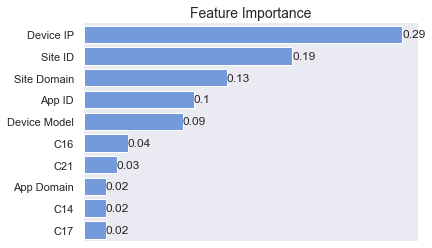

In [90]:
importances_df = pd.DataFrame({"feature_names" : search_cv.best_estimator_.feature_names_in_, 
                               "importances" : search_cv.best_estimator_.named_steps['classifier'].feature_importances_})
display_names = {'device_ip':'Device IP', 'site_id':'Site ID','site_domain':'Site Domain','app_id':'App ID','device_model':'Device Model','C16':'C16','C21':'C21','C14':'C14','C17':'C17','app_domain':'App Domain'}
importances_df['feature_names']=importances_df['feature_names'].map(display_names)
g = sns.barplot(data=importances_df.round(2).sort_values(['importances'], ascending=False).head(10), 
                x="importances", 
                y="feature_names",color='cornflowerblue')
sns.despine(bottom=True, left=True)

# setting x ticks as empty
g.set(xticks=[])
g.set(xlabel=None)
g.set(ylabel=None)
g.set_title("Feature Importance", fontsize=14)
for value in g.containers:
    g.bar_label(value)

0          Site ID
1      Site Domain
2              NaN
3           App ID
4       App Domain
5              NaN
6              NaN
7        Device IP
8     Device Model
9              NaN
10             NaN
11             NaN
12             NaN
13             C14
14             NaN
15             C16
16             C17
17             NaN
18             NaN
19             NaN
20             C21
Name: feature_names, dtype: object